# Manufacturing Layout Optimisation

This notebook demonstrates **job shop layout optimisation** using:
1. Discrete-Event Simulation (DES) for job processing.
2. Simulated Annealing to explore different station layouts.
3. Comparison of initial and optimised layouts by average completion time.


In [75]:
import simpy
import random
import matplotlib.pyplot as plt


## Job Shop Simulation Class


In [76]:
class JobShop:
    def __init__(self, env, stations):
        self.env = env
        self.stations = {name: simpy.Resource(env, capacity=1) for name in stations}

    def process_job(self, job_id, route):
        total_time = 0
        for station, duration in route:
            with self.stations[station].request() as req:
                yield req
                yield self.env.timeout(duration)
                total_time += duration
        return total_time


## Simulation Function


In [77]:
def simulate_layout(layout, num_jobs=10):
    env = simpy.Environment()
    shop = JobShop(env, layout)
    job_times = []

    def job_process(job_id):
        route = [(station, random.randint(1, 5)) for station in layout]
        start = env.now
        yield env.process(shop.process_job(job_id, route))
        job_times.append(env.now - start)

    for j in range(num_jobs):
        env.process(job_process(j))

    env.run()
    return sum(job_times)/len(job_times)


## Simulated Annealing Optimisation


In [78]:
def simulated_annealing(stations, iterations=50, initial_temp=10, cooling_rate=0.95):
    current_layout = stations.copy()
    best_layout = stations.copy()
    best_score = simulate_layout(best_layout)
    current_score = best_score
    history = [best_score]

    temp = initial_temp

    for _ in range(iterations):
        candidate = current_layout.copy()
        i, j = random.sample(range(len(candidate)), 2)
        candidate[i], candidate[j] = candidate[j], candidate[i]
        score = simulate_layout(candidate)

        # Accept better or occasionally worse layout
        if score < current_score or random.random() < (2.718 ** ((current_score - score) / temp)):
            current_layout = candidate
            current_score = score
            if score < best_score:
                best_layout = candidate
                best_score = score

        temp *= cooling_rate
        history.append(best_score)

    return best_layout, best_score, history


## Run Optimisation


In [123]:
stations = ['A', 'B', 'C']  # Example stations
best_layout, best_score, history = simulated_annealing(stations, iterations=50)

print(f"Initial layout {stations} -> Avg Time {simulate_layout(stations):.2f}")
print(f"Optimised layout {best_layout} -> Avg Time {best_score:.2f}")


Initial layout ['A', 'B', 'C'] -> Avg Time 26.10
Optimised layout ['B', 'A', 'C'] -> Avg Time 20.10


## Visualise Optimisation Progress


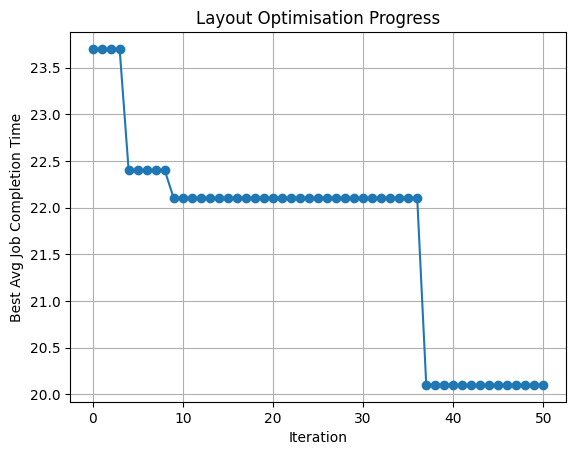

In [125]:
plt.plot(history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Best Avg Job Completion Time')
plt.title('Layout Optimisation Progress')
plt.grid(True)
plt.show()


### Notes & Extensions
- Increase `n_jobs` for more stable simulation results.
- Tune `T`, `cooling`, and `n_iter` for better optimisation performance.
- Can extend to more stations or realistic processing distributions.
